C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Algorithm: KMeans
Silhouette Score: 0.4490844509524467

Algorithm: DBSCAN
Silhouette Score: 0.5281235340404018

Algorithm: AgglomerativeClustering
Silhouette Score: 0.4604174074398789

Algorithm: MeanShift
Silhouette Score: 0.38023058689144085

Algorithm: SpectralClustering
Silhouette Score: 0.029513388199842797

Algorithm: GaussianMixture
Silhouette Score: 0.20849043321625735

Algorithm: Birch
Silhouette Score: 0.5682730420339861

Algorithm: AffinityPropagation
Silhouette Score: 0.34088631974260913

Algorithm: OPTICS
Silhouette Score: 0.06546641735015506

L'algorithme choisi est : Birch


C:\Users\user\AppData\Local\Temp\ipykernel_22396\2086269207.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clients['nomcli'], y=top_clients['montant_total_rapatrie'], ax=ax, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_22396\2086269207.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clients['nomcli'], y=top_clients['montant_total_rapatrie'], ax=ax, palette='viridis')
C:\Users\user\AppData\Local\Temp\ipykernel_22396\2086269207.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clients['nomcli'],

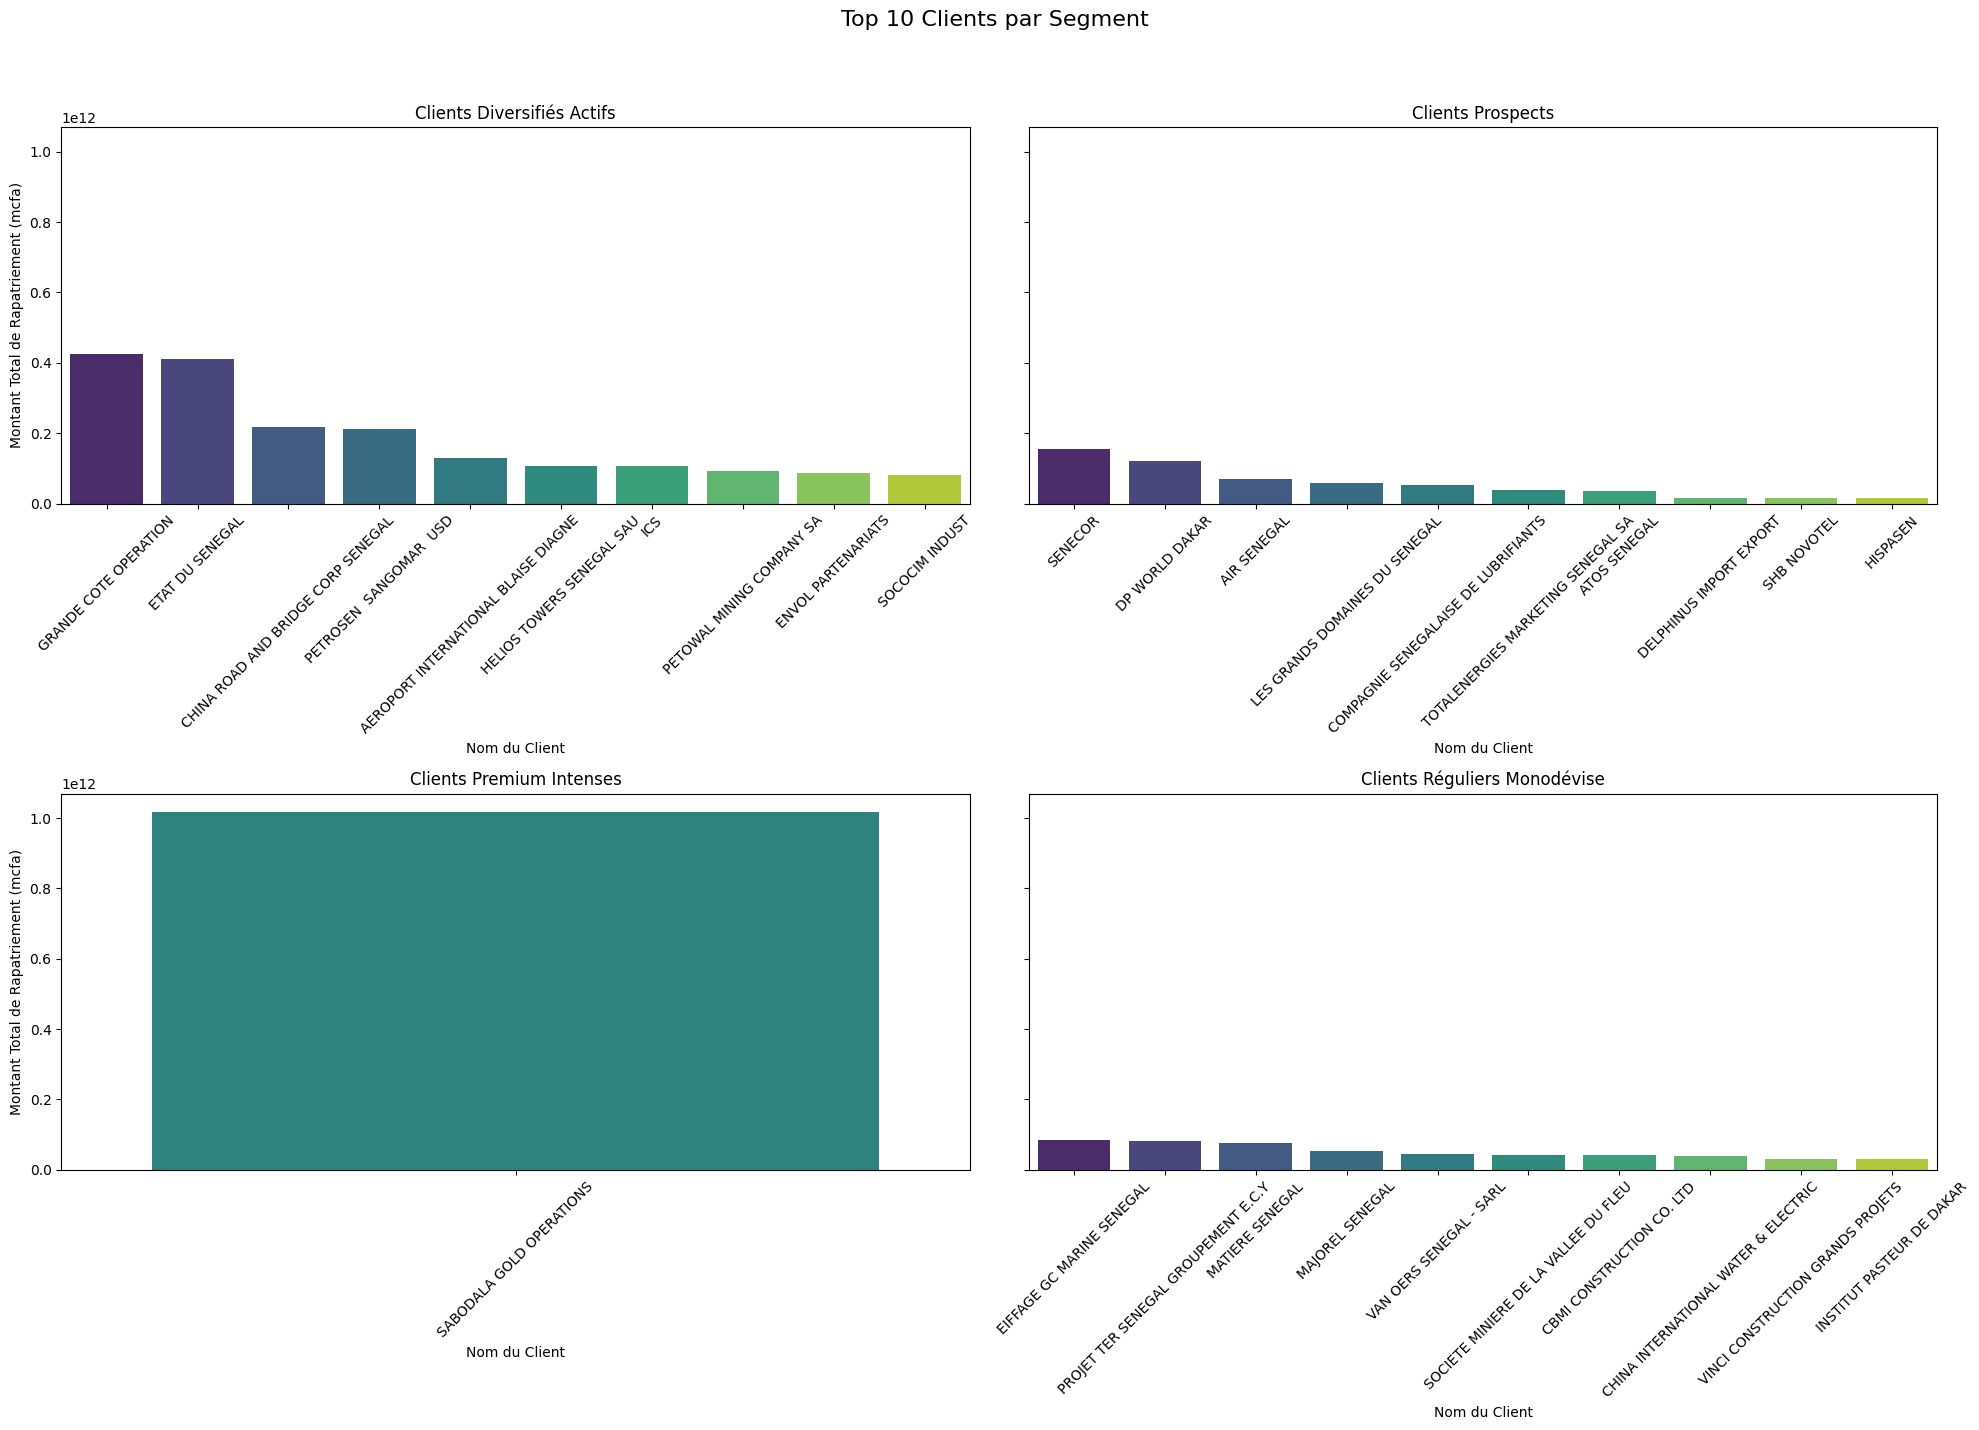

                              montant_total_rapatrie  montant_moyen_rapatrie  \
Segment                                                                        
Clients Diversifiés Actifs              1.246858e+11            6.379279e+09   
Clients Premium Intenses                1.018421e+12            2.624795e+09   
Clients Prospects                       1.372367e+10            3.494193e+07   
Clients Réguliers Monodévise            1.419242e+09            8.432227e+07   

                              nombre_devises_distinctes  \
Segment                                                   
Clients Diversifiés Actifs                     1.437500   
Clients Premium Intenses                       3.000000   
Clients Prospects                              2.089286   
Clients Réguliers Monodévise                   1.335479   

                              frequence_transactions  annee_active  Cluster  \
Segment                                                                       
Client

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, Birch, AffinityPropagation, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
file_path = 'Raptriement_new.csv'
data = pd.read_csv(file_path, sep=';')

# Supprimer les espaces avant les noms de colonnes
data.columns = data.columns.str.strip()

# Conversion de la colonne 'dou' en format date
data['dou'] = pd.to_datetime(data['dou'], format='%d/%m/%Y')

# Calculer les caractéristiques pour chaque client
client_features = data.groupby('nomcli').agg(
    montant_total_rapatrie=pd.NamedAgg(column='mcfa', aggfunc='sum'),
    montant_moyen_rapatrie=pd.NamedAgg(column='mcfa', aggfunc='mean'),
    nombre_devises_distinctes=pd.NamedAgg(column='dev', aggfunc='nunique'),
    frequence_transactions=pd.NamedAgg(column='mcfa', aggfunc='count'),
    annee_active=pd.NamedAgg(column='dou', aggfunc=lambda x: x.dt.year.nunique())
).reset_index()

# Standardisation des données
scaler = StandardScaler()
client_features_scaled = scaler.fit_transform(client_features.drop('nomcli', axis=1))

# Utiliser plusieurs algorithmes de clustering
algorithms = {
    'KMeans': KMeans(n_clusters=4, random_state=42),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=4),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42),
    'GaussianMixture': GaussianMixture(n_components=4, random_state=42),
    'Birch': Birch(n_clusters=4),
    'AffinityPropagation': AffinityPropagation(random_state=42),
    'OPTICS': OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
}

results = {}

# Appliquer chaque algorithme et évaluer les résultats
for name, algorithm in algorithms.items():
    try:
        clusters = algorithm.fit_predict(client_features_scaled)
        if len(set(clusters)) > 1:  # Vérifier qu'il y a plus d'un cluster
            silhouette_avg = silhouette_score(client_features_scaled, clusters)
            results[name] = {
                'clusters': clusters,
                'silhouette_score': silhouette_avg
            }
    except Exception as e:
        print(f"Error with {name}: {e}")

# Afficher les résultats de l'évaluation
for name, metrics in results.items():
    print(f"Algorithm: {name}")
    print(f"Silhouette Score: {metrics['silhouette_score']}\n")

# Choisir l'algorithme avec le meilleur score de silhouette
best_algorithm_name, best_algorithm_metrics = max(results.items(), key=lambda x: x[1]['silhouette_score'])
best_clusters = best_algorithm_metrics['clusters']

print(f"L'algorithme choisi est : {best_algorithm_name}")

# Ajouter les clusters aux données originales
client_features['Cluster'] = best_clusters

# Nommer les segments en tenant compte des résultats
segment_names = {
    0: "Clients Diversifiés Actifs",
    1: "Clients Prospects",
    2: "Clients Premium Intenses",
    3: "Clients Réguliers Monodévise"
}
client_features['Segment'] = client_features['Cluster'].map(segment_names)

# Identifier les top 10 clients de chaque segment
top_clients_per_segment = {}
for segment in segment_names.values():
    top_clients = client_features[client_features['Segment'] == segment].nlargest(10, 'montant_total_rapatrie')
    top_clients_per_segment[segment] = top_clients

# Créer une figure avec plusieurs sous-graphiques pour visualiser les top 10 clients de chaque segment
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)
fig.suptitle('Top 10 Clients par Segment', fontsize=16)

# Tracer des graphiques en barres pour chaque segment
for ax, (segment, top_clients) in zip(axes.flatten(), top_clients_per_segment.items()):
    sns.barplot(x=top_clients['nomcli'], y=top_clients['montant_total_rapatrie'], ax=ax, palette='viridis')
    ax.set_title(segment)
    ax.set_xlabel('Nom du Client')
    ax.set_ylabel('Montant Total de Rapatriement (mcfa)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Analyse des segments en filtrant uniquement les colonnes numériques
numeric_columns = client_features.select_dtypes(include=['number']).columns
segment_analysis = client_features.groupby('Segment')[numeric_columns].mean()
segment_counts = client_features['Segment'].value_counts()
segment_analysis['nombre_de_clients'] = segment_counts

# Afficher l'analyse des segments
print(segment_analysis)


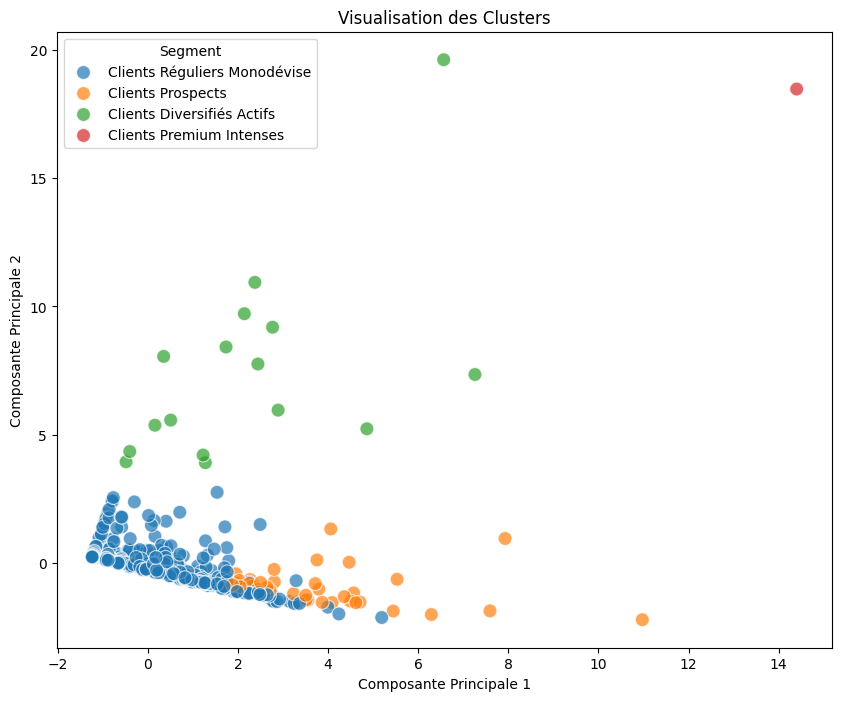

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Réduction de la dimension à 2D pour la visualisation
pca = PCA(n_components=2)
principal_components = pca.fit_transform(client_features_scaled)

# Création d'un DataFrame pour les composants principaux et les clusters
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Segment'] = client_features['Segment']

# Visualisation des clusters avec des couleurs différentes
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Segment', palette='tab10', s=100, alpha=0.7)
plt.title('Visualisation des Clusters')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Segment')
plt.show()

In [12]:
# Sélectionner les colonnes à enregistrer

# Ajouter la colonne 'cli'
client_features = client_features.merge(data[['nomcli', 'cli']].drop_duplicates(), on='nomcli', how='left')

output_df = client_features[['nomcli', 'cli', 'montant_total_rapatrie', 'montant_moyen_rapatrie', 'nombre_devises_distinctes', 'frequence_transactions', 'annee_active', 'Segment']]

# Enregistrer le DataFrame en fichier Excel
output_file_path = 'segmentation_clients.xlsx'
output_df.to_excel(output_file_path, index=False)

print(f"Fichier Excel enregistré sous le nom : {output_file_path}")

Fichier Excel enregistré sous le nom : segmentation_clients.xlsx
